In [1]:
pip install investpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.6 MB/s 
     |████████████████████████████████| 235 kB 45.3 MB/s 
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481592 sha256=93c627a54f116703f73dc61f537594737942e0acb0e3fa4bc8bfd565deef48b8
  Stored in directory: /root/.cache/pip/wheels/96/a8/a5/0d33c72eaf00b41df7b9dc1e15d2b7c7154b3f1379ed350211
Successfully built investpy


In [2]:
import numpy as np
import requests 
from bs4 import BeautifulSoup
import re
import csv 
import investpy 
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use("seaborn-pastel")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf

from torch.autograd import Variable 
%matplotlib inline

In [3]:

#getting data of vnindex 30 from 1/1/2012 to current day 
today = str(date.today())
today = today.split('-')
today = '/'.join(today[::-1])
df_vn30 = investpy.get_index_historical_data(index = 'vn 30',
                                        country = 'Vietnam',
                                        from_date = '1/1/2012',
                                        to_date = today,
                                        interval = 'daily'
                                        )
df_hnx = investpy.get_index_historical_data(index = 'hnx 30',
                                        country = 'Vietnam',
                                        from_date = '1/1/2012',
                                        to_date = today,
                                        interval = 'daily'
                                        )

In [4]:
df_vn30.info()
df_vn30.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2652 entries, 2012-01-03 to 2022-08-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      2652 non-null   float64
 1   High      2652 non-null   float64
 2   Low       2652 non-null   float64
 3   Close     2652 non-null   float64
 4   Volume    2652 non-null   int64  
 5   Currency  2652 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 145.0+ KB


,Open,High,Low,Close,Volume
count,2652.000000,2652.000000,2652.000000,2652.000000,2.652000e+03
mean,809.835083,815.297941,804.106603,809.939657,1.228000e+05
std,295.438267,297.945663,292.382500,295.338908,1.248959e+06
min,374.020000,374.020000,374.020000,374.020000,0.000000e+00
25%,587.080000,590.582500,582.807500,587.412500,3.184075e+04
50%,687.690000,691.700000,681.005000,688.195000,4.829750e+04
75%,927.502500,933.330000,921.780000,927.485000,7.700425e+04
max,1576.520000,1587.000000,1567.670000,1572.460000,3.439100e+07


In [5]:
df_hnx.info()
df_hnx.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2014-11-04 to 2022-08-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      1947 non-null   float64
 1   High      1947 non-null   float64
 2   Low       1947 non-null   float64
 3   Close     1947 non-null   float64
 4   Volume    1947 non-null   int64  
 5   Currency  1947 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 106.5+ KB


,Open,High,Low,Close,Volume
count,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000
mean,264.913112,268.163282,261.988721,265.171782,32711.707242
std,173.750623,176.696076,171.099706,173.832897,22524.194726
min,124.580000,127.510000,123.490000,125.070000,5902.000000
25%,162.830000,164.305000,161.580000,162.855000,16910.500000
50%,190.980000,192.700000,189.680000,191.280000,25623.000000
75%,252.520000,254.600000,250.515000,252.710000,41709.000000
max,874.020000,892.180000,851.040000,874.020000,162663.000000


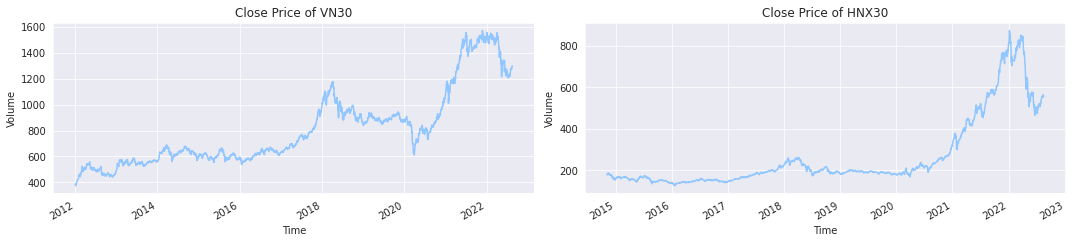

In [6]:
df = [df_vn30,df_hnx]
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i,index in enumerate(df,1):
    plt.subplot(2,2,i)
    index['Close'].plot()
    plt.ylabel('Volume')
    plt.xlabel('Time')
    if i == 1 : plt.title('Close Price of VN30')
    else : plt.title('Close Price of HNX30')
plt.tight_layout()

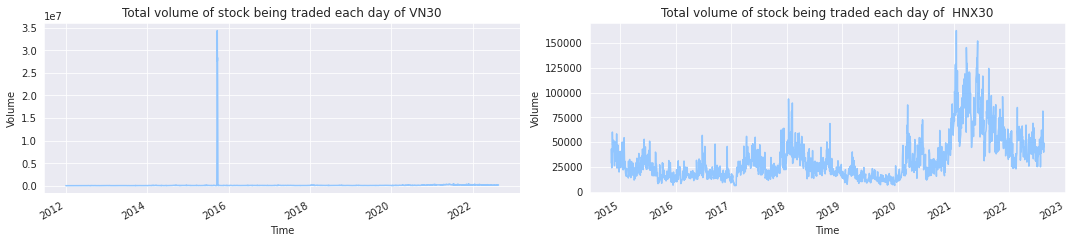

In [7]:

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i,index in enumerate(df,1):
    plt.subplot(2,2,i)
    index['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel('Time')
    if i == 1 : plt.title('Total volume of stock being traded each day of VN30')
    else : plt.title('Total volume of stock being traded each day of  HNX30')
plt.tight_layout()

In [8]:
#Từ hình ảnh trên ta thấy được có những ngày có lượng trao đổi cực lớn vào khoảng thời gian từ năm 2014-2016
#Những outlier này lớn hơn so với các giá trị giao dịch hàng ngày rất nhiều
#Ta sẽ kiểm tra xem có bao nhiêu ngày có outlier với giá trị của volume lơn hơn 500000 
outlier = df_vn30.loc[df_vn30['Volume'] > 500000] 
print(outlier)
df_vn30 = df_vn30.drop("Currency", axis='columns')

              Open    High     Low   Close    Volume Currency
Date                                                         
2015-09-21  583.37  590.46  582.81  590.46  29559000      VND
2015-09-22  591.81  593.93  589.01  592.78  34391000      VND
2015-09-23  590.58  593.13  588.24  591.23  27631000      VND
2015-09-24  591.39  593.67  589.42  589.42  28408000      VND
2015-09-25  588.91  591.12  584.87  588.11  22919000      VND


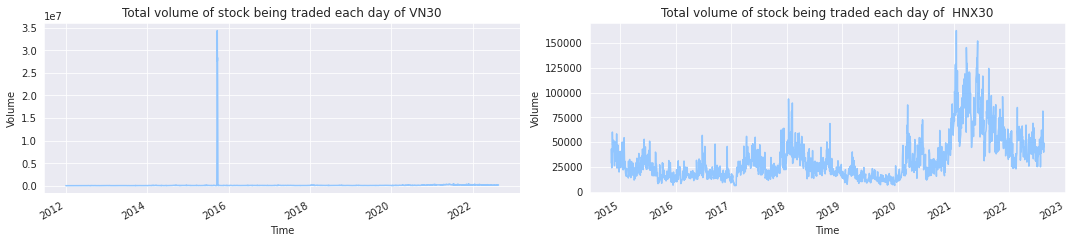

In [9]:
# các outlier đóng góp rất nhỏ trong dữ liệu toàn thời gian có thể trong 5 ngày này xảy ra một sự kiện lớn hoặc nguồn đầu tư lớn 
# để giúp không skew phân phối ta drop dữ liệu tại 5 ngày này 
#df_vn30 = df_vn30.drop(['2015-09-21','2015-09-22','2015-09-23','2015-09-24','2015-09-25'])
df = [df_vn30,df_hnx]
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i,index in enumerate(df,1):
    plt.subplot(2,2,i)
    index['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel('Time')
    if i == 1 : plt.title('Total volume of stock being traded each day of VN30')
    else : plt.title('Total volume of stock being traded each day of  HNX30')
plt.tight_layout()

In [10]:
#Thiết lập rolling average để xem tính xu hướng của cổ phiếu bằng cách tính trung bình theo lùi từng ngày ở đây là 10 20 50 ngày
rolling_window = [10,20,50]
for window in rolling_window:
  for index in df : 
    column_name = f"Moving average for {window} days"
    df_vn30[column_name] = df_vn30['Close'].rolling(window).mean()
    df_hnx[column_name] = df_hnx['Close'].rolling(window).mean()

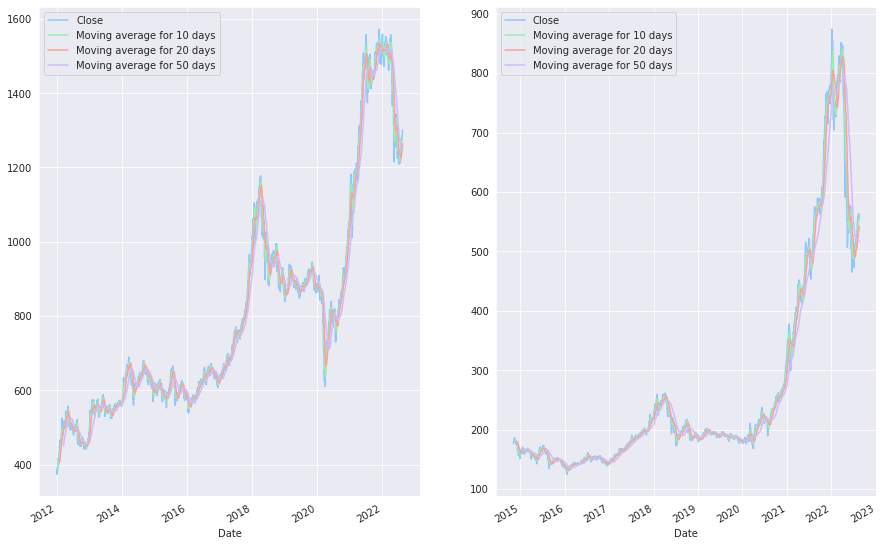

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_figheight(10)
fig.set_figwidth(15)
df_vn30[['Close','Moving average for 10 days','Moving average for 20 days','Moving average for 50 days']].plot(ax=axes[0])
df_hnx[['Close','Moving average for 10 days','Moving average for 20 days','Moving average for 50 days']].plot(ax=axes[1])

In [12]:
#now we do lstm :D 
data = df_vn30.filter(['Close']).values
training_size = int(np.ceil(len(data)*0.85)) #tạo training size
print(data)
Scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = Scaler.fit_transform(data) #scale data về trong khoảng 1 lý do cho việc này là trong lstm ngoài việc tối ưu thì còn tổn tại 
#một hàm kích hoạt là hàm tanh 


[[ 385.28]
 [ 385.42]
 [ 376.97]
 ...
 [1295.1 ]
 [1300.4 ]
 [1299.93]]


In [13]:
#phần cốt lõi hiểu về model vận hành lstm nhận vào một tệp giữ liệu là tập hợp các giá trị của các ngày trước đó x ngày train để tìm ra giá trị tại ngày x+1 
#ở đây ta vận hành bằng cách chọn lùi 60 ngày để tính toán giá trị tại ngày thứ 61
train_data = scaled_data[0:int(training_size),:]
x_train,y_train = [],[]
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00939555, 0.00951237, 0.00246153, 0.        , 0.00425553,
       0.00970428, 0.01258302, 0.01164848, 0.01703047, 0.01983412,
       0.02078535, 0.02425653, 0.03390241, 0.03364374, 0.04528387,
       0.04868829, 0.05250993, 0.06311538, 0.06290678, 0.06128801,
       0.06282334, 0.072561  , 0.07569006, 0.07026635, 0.06025333,
       0.06358266, 0.06012817, 0.05800874, 0.06441708, 0.0762825 ,
       0.0736374 , 0.08089683, 0.08542772, 0.08657088, 0.09331297,
       0.08917426, 0.09275391, 0.09761857, 0.10807383, 0.12593038,
       0.11213745, 0.11004306, 0.09598311, 0.09429759, 0.09064284,
       0.09378859, 0.09780214, 0.10747305, 0.10250826, 0.10280031,
       0.10619639, 0.11079403, 0.10974267, 0.11583392, 0.11953039,
       0.10713094, 0.10890825, 0.10385167, 0.1051784 , 0.10993458])]
[0.1053536263809619]

[array([0.00939555, 0.00951237, 0.00246153, 0.        , 0.00425553,
       0.00970428, 0.01258302, 0.01164848, 0.01703047, 0.01983412,
       0.02078535, 0.02425653, 0.033

In [14]:
def Lstm_model(X, y):
    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    regressor.fit(X, y, epochs = 100, validation_split=0.1, batch_size = 64, verbose=1, callbacks=[es])
    return regressor

In [18]:
model = Lstm_model(x_train,y_train)

Epoch 1/100
31/31 [==============================] - 13s 196ms/step - loss: 0.0150 - val_loss: 0.0088
Epoch 2/100
31/31 [==============================] - 4s 144ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 3/100
31/31 [==============================] - 4s 144ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 4/100
31/31 [==============================] - 5s 145ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 5/100
31/31 [==============================] - 5s 146ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 6/100
31/31 [==============================] - 5s 146ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 7/100
31/31 [==============================] - 5s 145ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 8/100
31/31 [==============================] - 5s 146ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/100
31/31 [==============================] - 5s 146ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 10/100
31/31 [==============================] - 4s 145ms/step - loss: 0.0011 - val_l

In [31]:
test_data = scaled_data[training_size - 60: , :]
# tạo tệp test bằng cách sample lại các từ tệp scaled data còn lại
x_test = []
y_test = data[training_size:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Chuyển lại về numpy array
x_test = np.array(x_test)

# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Lấy giá trị dự báo 
predictions = model.predict(x_test)
predictions = Scaler.inverse_transform(predictions)

# Tính (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

96.37198442481034

2255
              Close
Date               
2012-01-03   385.28
2012-01-04   385.42
2012-01-05   376.97
2012-01-06   374.02
2012-01-09   379.12
...             ...
2022-08-12  1280.96
2022-08-15  1293.79
2022-08-16  1295.10
2022-08-17  1300.40
2022-08-18  1299.93

[2652 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


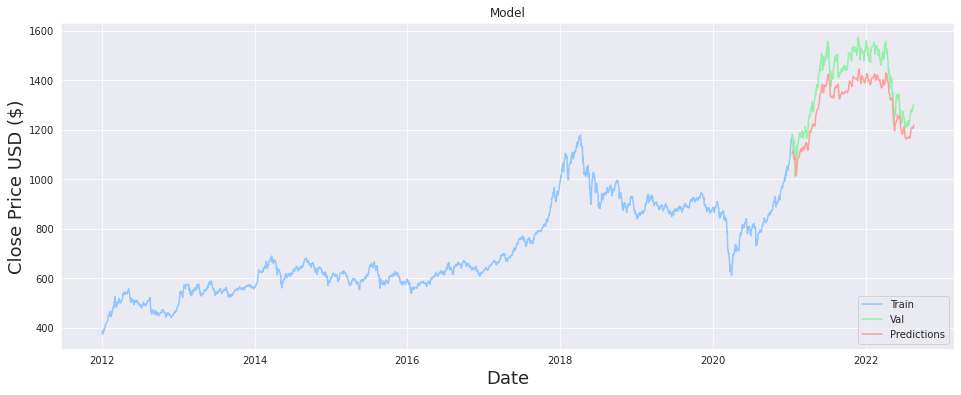

In [42]:
print(training_size)
new_data = df_vn30.filter(['Close'])
print(new_data)
train = new_data[:training_size]
valid = new_data[training_size:]
valid['Predictions'] = predictions
# Vẽ đồ thị 
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [43]:
#Qua notebook hiểu hơn về cách mà lstm vận hành cũng như cách sample data cho model
#Nếu bổ sung có thể so sánh với các cách làm truyền thống hơn bằng thống kê không dùng đến nn như Exponential hoặc Simple moving average 
 
